In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.2.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True


In [2]:

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


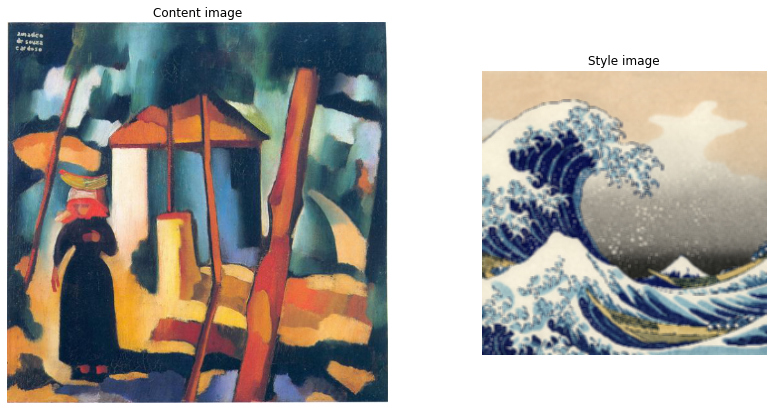

In [10]:

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [12]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [13]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

In [14]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

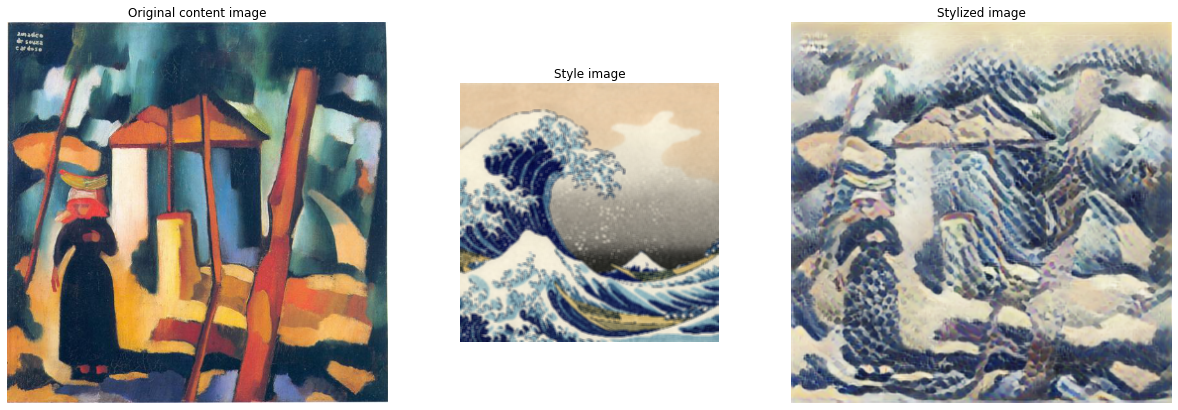

In [15]:

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [8]:
# @title To Run: Load more images { display-mode: "form" }

content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

73728/66306 [=================================] - 0s 1us/step
